In [1]:
import numpy as np
import sys
sys.path.append("../../src/")
import utility
import pandas as pd

from matplotlib import pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import ttest_ind

from scipy.stats import kruskal
from statsmodels.stats.proportion import proportions_chisquare

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib

import statsmodels.api as sm

from scipy import stats

import pandas as pd

import math


In [2]:
df_IEA_P1 = pd.read_csv("../../output/IEA_P1.csv").set_index("sid")
df_data = utility.load_data()
df_PCs = utility.load_SSL_PCs()

df_merged = pd.merge(df_data, df_IEA_P1, left_index = True, right_index = True)
df_merged = pd.merge(df_merged, df_PCs, left_index = True, right_index = True)



/ocean/projects/asc170022p/juc91/anaconda/envs/IEA/lib/python3.7/site-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
../../src/utility.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cov[df_cov == ""] = "nan"
/ocean/projects/asc170022p/juc91/anaconda/envs/IEA/lib/python3.7/site-packages/pandas/core/frame.py:3718: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [3]:
covariances = ["Age_P1", "gender", "race", 
               "smoking_status_P1", 
               "BMI_P1", "ATS_PackYears_P1",
               "FEV1pp_utah_P1", "FEV1_FVC_utah_P1", 
               "SGRQ_scoreTotal_P1", "MMRCDyspneaScor_P1", 
               "distwalked_P1", "Frequent_Exacerbator_P1",
               "Perc15_Insp_Thirona_P1","pctEmph_Thirona_P1", "pctGasTrap_Thirona_P1", "Pi10_Thirona_P1", 
               "WallAreaPct_seg_Thirona_P1", "perc15_ratio", 
               "delta_FEV1pp_P1P2", "delta_FEV1FVC_P1P2",
               "Frequent_Exacerbator_P2", "5-year Mortality_P1", 
           ] 

axes_list = ["IEA0", "IEA1",  'PCA_emphysema_axis', 'PCA_airway_axis', "PC0_P1", "PC1_P1"]


In [4]:
cov_label = [iii.replace("Frequent_Exacerbator_P1", "Frequent Exacerbator (History)")\
             .replace("Frequent_Exacerbator_P2", "Frequent Exacerbator (Future)")\
             .replace("smoking_status_P1", "%Current Smoker").replace("_P1", "").replace("P2", "")\
             .replace("ATS_", "").replace("_Thirona", "").replace("FEV1pp_utah", "FEV$_1$%predicted")\
             .replace("FEV1_FVC_utah", "FEV$_1$/FVC").replace("distwalked", "6-Minute-Walk Distance").replace("pctEmph", "%Emphysema at -950HU")\
             .replace("Perc15_Insp", "perc15").replace("pctGasTrap", "%Gas Trapping").replace("gender", "Gender, %females")\
             .replace("race", "Race, %African-American").replace("PackYears", "Pack Years").replace("WallAreaPct_seg", "%WA segmental")\
             .replace("BMI", "Body Mass Index (BMI)").replace("Pi10", "Pi10").replace("SGRQ_scoreTotal", "SGRQ Total Score")\
             .replace("MMRCDyspneaScor", "mMRC Dyspnea Score")\
             .replace("FEV1pp", "FEV$_1$%predicted").replace("FEV1FVC", "FEV$_1$/FVC").replace("WApct", "%WA segmental")\
             .replace("delta_", "$\Delta$")\
             .replace("perc15_ratio", "$Q_{perc15_{peel-core}}$")
             for iii in covariances]

col_labels = ["IEA$_{emph}$", "IEA$_{airway}$", "FA$_{emph}$", "FA$_{airway}$", "PCA-I1", "PCA-I2"]

In [5]:
df_used = df_merged[covariances + axes_list]
corr_coef = df_used.corr()[axes_list].loc[covariances].to_numpy()
corr_coef = np.around(corr_coef, 2)



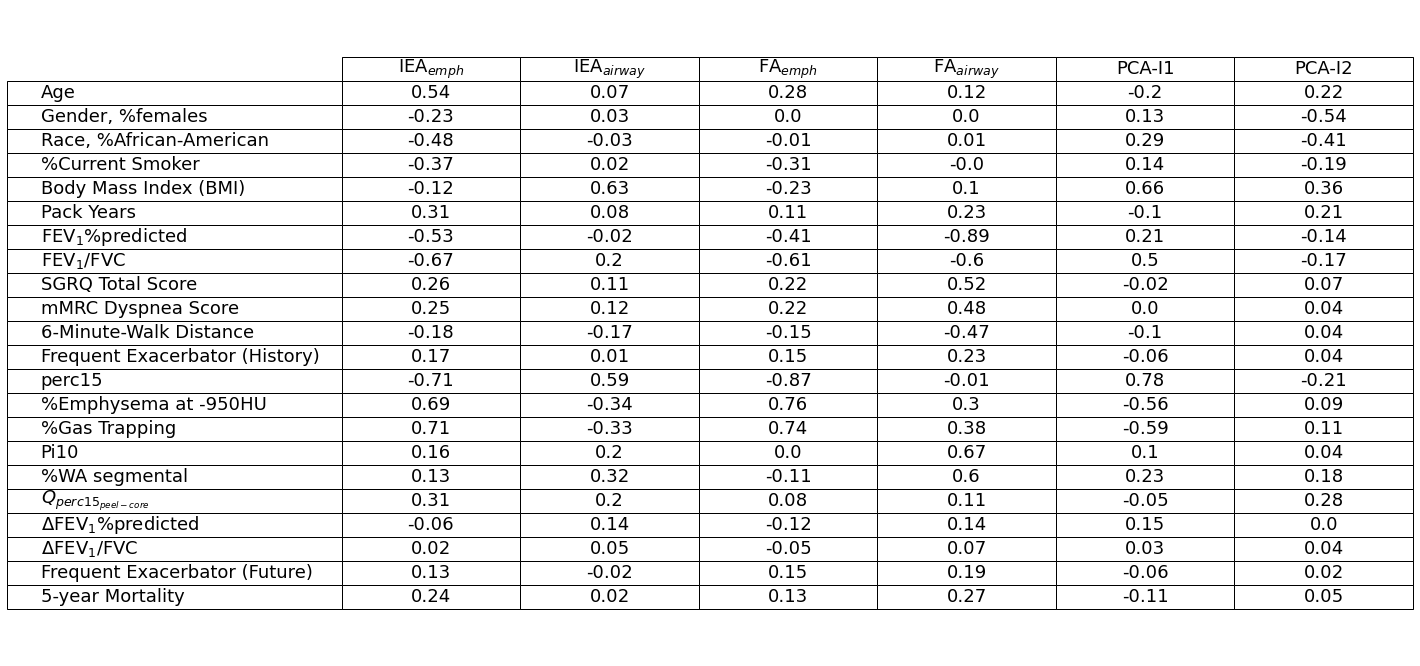

In [6]:
fig, ax = plt.subplots(figsize=(16,12))

the_table=plt.table(cellText=corr_coef, rowLabels=cov_label, 
                    colLabels = col_labels,
                     colWidths = [.1]*corr_coef.shape[1], loc='center', fontsize = 50, cellLoc = "center"
                   )

plt.axis('off')

the_table.auto_set_font_size(False)
the_table.set_fontsize(18)
the_table.scale(2, 2)